In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
import random
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy import stats
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics
import statistics
import matplotlib.pyplot as plt
plt.style.use('science')
# from sklearn.model_selection import KFold, cross_val_score

Regressions = ['Linear Regression', 
               'Ridge',  'Lasso', 
               'ElasticNet',  'SGD Regressor', 
               'RandomForest Regressor','SVR']
models = [LinearRegression(normalize=True),
         #RANSACRegressor(base_estimator=LinearRegression(), max_trials=100),
         Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42),
         Lasso(alpha=0.1,precompute=True,positive=True,selection='random',
            random_state=42),
         ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42),
         SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000),
         RandomForestRegressor(n_estimators=1000),
         SVR(kernel='rbf', C=1000000, epsilon=0.001)]

def model_score(df,label):
    Score = pd.DataFrame({"Regression":Regressions})
    j = 0
    acc = []
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(metrics.r2_score(Y_test,predictions))
        j = j+1     
    Score["R2 Square"] = acc
    Score.sort_values(by="R2 Square", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score


    
def removearray(L,arr):
    ind = 0
    size = len(L)
    while ind != size and not np.array_equal(L[ind],arr):
        ind += 1
    if ind != size:
        L.pop(ind)
    else:
        raise ValueError('array not found in list.')
        
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.zeros(n_feat,dtype=np.bool) 
        j = 0
        while(j<0.3*n_feat):
            p = random.uniform(0,1)
            position = random.randrange(n_feat)
            if(p>=0.5 and chromosome[position]==0):
                chromosome[position]=1
                j=j+1
        if(sum(chromosome)==0):
            position = random.randrange(c)
            chromosome[position] = 1            
        population.append(chromosome)
    return population

def evaluate(true, predicted):
    r2_square = metrics.r2_score(true, predicted)
   # cross_validation=cross_val(LinearRegression())
    socre = r2_square
    return socre


def fitness_score(population):
    scores = []
    for chromosome in population:
       # print("chromosome:",chromosome)
        model.fit(X_train.iloc[:,chromosome],Y_train)
        predictions = model.predict(X_test.iloc[:,chromosome])
        scores.append(evaluate(Y_test,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                    
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

def roulette_selection(pop_after_fit,n_parents,scores,eliteSize):
    population_nextgen = []
    cum_sum = []
    cum_per = []
    cum_sum = np.cumsum(scores)
    cum_perc = 100*cum_sum/np.sum(scores)
#     print("scores_size:",len(scores))
#     print("cum_sum_size:",len(cum_sum))
    for i in range(0, eliteSize):
        population_nextgen.append(pop_after_fit[i])
    for i in range(0, n_parents - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(cum_sum)):
            if pick <= cum_perc[i]:
                population_nextgen.append(pop_after_fit[i])
                break
    return population_nextgen

def crossover(pop_after_sel,cross_rate):
   # print("pop_after_sel:",len(pop_after_sel))
    pop_nextgen = pop_after_sel
    random.shuffle(pop_nextgen)
    num_of_pairs = round(len(pop_nextgen)*cross_rate/2)
    for i in range(num_of_pairs):
        length = len(pop_nextgen)
        pop_nextgen1_index = random.randrange(length)
        pop_nextgen2_index = random.randrange(length)
        while(pop_nextgen1_index == pop_nextgen2_index):
            pop_nextgen2_index = random.randrange(length)
        pop_nextgen1 = pop_nextgen[pop_nextgen1_index]
        pop_nextgen2 = pop_nextgen[pop_nextgen2_index]
        child_1 , child_2 = pop_nextgen1 , pop_nextgen2
        new_par1 = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        new_par2 = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par1)
        pop_nextgen.append(new_par2)
        removearray(pop_nextgen,pop_nextgen1)
        removearray(pop_nextgen,pop_nextgen2)
    return pop_nextgen

def mutation(pop_after_cross,mutation_rate,n_feat):   
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen


def adaptive_crossover(pop_after_sel,k1,k3,scores):
   # pop_nextgen = pop_after_sel
    fmax = scores[:1]
    favg = sum(scores)/len(scores)
    pop_cross_choose = []
    pop_nextgen = []
    for n in range(0,len(pop_after_sel)):
        if scores[n] <= favg:
            pc = k3
        elif(scores[n] == fmax):
            pc = 0
        else:
            pc = k1*(fmax-scores[n])/(fmax-favg)
        random_number = random.uniform(0, 1)
        if(pc>random_number):
            pop_cross_choose.append(pop_after_sel[n])
        else:
            pop_nextgen.append(pop_after_sel[n])
    z =  len(pop_cross_choose)
    for i in range(0,z):
        length = len(pop_cross_choose)
        pop_nextgen1_index = random.randrange(length)
        pop_nextgen2_index = random.randrange(length)
        while(pop_nextgen1_index == pop_nextgen2_index):
            pop_nextgen2_index = random.randrange(length)
        pop_nextgen1 = pop_cross_choose[pop_nextgen1_index]
        pop_nextgen2 = pop_cross_choose[pop_nextgen2_index]
        child_1 , child_2 = pop_nextgen1 , pop_nextgen2
        new_par1 = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        new_par2 = np.concatenate((child_2[:len(child_2)//2],child_1[len(child_1)//2:]))
        pop_nextgen.append(new_par1)
        pop_nextgen.append(new_par2)
        removearray(pop_cross_choose,pop_nextgen1)
        removearray(pop_cross_choose,pop_nextgen2)
        if(len(pop_cross_choose)==1):
            pop_nextgen.append(pop_cross_choose[0])
            break
        elif(len(pop_cross_choose)==0):
            break
    return pop_nextgen

def adaptive_mutation(pop_after_cross,k2,k4,scores,n_feat):
    fmax = scores[:1]
    favg = sum(scores)/len(scores)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        if scores[n] <= favg:
            pm = k4
        elif(scores[n] == fmax):
            pm = 0
        else:
            pm = k2*(fmax-scores[n])/(fmax-favg)
        random_number = random.uniform(0, 1)
        if(pm>random_number):
            pos = randint(0,n_feat-1)
            chromo[pos] = not chromo[pos]
        pop_next_gen.append(chromo)
    return pop_next_gen
    

def generations1(population_nextgen,df,label,size,n_feat,n_parents,mutation_rate,cross_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test,tol_level):
    best_chromo= []
    best_score= []
    k1 = 0.5
    k2 = 0.5
    k3 = 1
    k4 = 1
    while True:
        for i in range(n_gen):
            scores, pop_after_fit = fitness_score(population_nextgen)
            variance_of_population = statistics.variance(scores)
            #print('Best score in generation',i+1,':',scores[:1])  #2
            #print("    variance is",variance_of_population)
            if(variance_of_population < tol_level):
                break
            pop_after_sel = roulette_selection(pop_after_fit,n_parents,scores,eliteSize = 2)
            # pop_after_cross = adaptive_crossover(pop_after_sel,k1,k3,scores)
            pop_after_cross = crossover(pop_after_sel,cross_rate)
            # population_nextgen = adaptive_mutation(pop_after_cross,k2,k4,scores,n_feat)
            population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
            #print('population_nextgen:',population_nextgen)  #2   \
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])   
        break
    return best_chromo,best_score

def generations2(population_nextgen,df,label,size,n_feat,n_parents,mutation_rate,cross_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test,tol_level):
    best_chromo= []
    best_score= []
    k1 = 0.5
    k2 = 0.5
    k3 = 1
    k4 = 1
    while True:
        for i in range(n_gen):
            scores, pop_after_fit = fitness_score(population_nextgen)
            variance_of_population = statistics.variance(scores)
           # print('Best score in generation',i+1,':',scores[:1])  #2
            #print("    variance is",variance_of_population)
            if(variance_of_population < tol_level):
                break
            pop_after_sel = roulette_selection(pop_after_fit,n_parents,scores,eliteSize = 2)
            pop_after_cross = adaptive_crossover(pop_after_sel,k1,k3,scores)
            # pop_after_cross = crossover(pop_after_sel,cross_rate)
            population_nextgen = adaptive_mutation(pop_after_cross,k2,k4,scores,n_feat)
            # population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
            # print('population_nextgen:',population_nextgen)  #2   \
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])   
        break
    return best_chromo,best_score
def generations3(population_nextgen,df,label,size,n_feat,n_parents,mutation_rate,cross_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test,tol_level):
    best_chromo= []
    best_score= []
    k1 = 0.5
    k2 = 0.5
    k3 = 1
    k4 = 0.9
    while True:
        for i in range(n_gen):
            scores, pop_after_fit = fitness_score(population_nextgen)
            variance_of_population = statistics.variance(scores)
           # print('Best score in generation',i+1,':',scores[:1])  #2
           # print("    variance is",variance_of_population)
            if(variance_of_population < tol_level):
                break
            pop_after_sel = roulette_selection(pop_after_fit,n_parents,scores,eliteSize = 2)
            pop_after_cross = adaptive_crossover(pop_after_sel,k1,k3,scores)
            # pop_after_cross = crossover(pop_after_sel,cross_rate)
            population_nextgen = adaptive_mutation(pop_after_cross,k2,k4,scores,n_feat)
            # population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
            # print('population_nextgen:',population_nextgen)  #2   \
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])   
        break
    return best_chromo,best_score
def generations4(population_nextgen,df,label,size,n_feat,n_parents,mutation_rate,cross_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test,tol_level):
    best_chromo= []
    best_score= []
    k1 = 0.5
    k2 = 0.5
    k3 = 0.9
    k4 = 1
    while True:
        for i in range(n_gen):
            scores, pop_after_fit = fitness_score(population_nextgen)
            variance_of_population = statistics.variance(scores)
           # print('Best score in generation',i+1,':',scores[:1])  #2
            # print("    variance is",variance_of_population)
            if(variance_of_population < tol_level):
                break
            pop_after_sel = roulette_selection(pop_after_fit,n_parents,scores,eliteSize = 2)
            pop_after_cross = adaptive_crossover(pop_after_sel,k1,k3,scores)
            # pop_after_cross = crossover(pop_after_sel,cross_rate)
            population_nextgen = adaptive_mutation(pop_after_cross,k2,k4,scores,n_feat)
            # population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
            # print('population_nextgen:',population_nextgen)  #2   \
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])   
        break
    return best_chromo,best_score
def generations5(population_nextgen,df,label,size,n_feat,n_parents,mutation_rate,cross_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test,tol_level):
    best_chromo= []
    best_score= []
    k1 = 0.5
    k2 = 0.5
    k3 = 0.9
    k4 = 0.9
    while True:
        for i in range(n_gen):
            scores, pop_after_fit = fitness_score(population_nextgen)
            variance_of_population = statistics.variance(scores)
            #print('Best score in generation',i+1,':',scores[:1])  #2
           # print("    variance is",variance_of_population)
            if(variance_of_population < tol_level):
                break
            pop_after_sel = roulette_selection(pop_after_fit,n_parents,scores,eliteSize = 2)
            pop_after_cross = adaptive_crossover(pop_after_sel,k1,k3,scores)
            # pop_after_cross = crossover(pop_after_sel,cross_rate)
            population_nextgen = adaptive_mutation(pop_after_cross,k2,k4,scores,n_feat)
            # population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
            # print('population_nextgen:',population_nextgen)  #2   \
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])   
        break
    return best_chromo,best_score

In [2]:
data = pd.read_csv("./industrial_dataset.csv")
label = data["Target"]
data.drop(["Unnamed: 0","Target"],axis = 1,inplace = True)
print("dataset:\n",data.shape[0],"Records\n",data.shape[1],"Features")

dataset:
 2888 Records
 50 Features


In [3]:
score_regression = model_score(data,label)
score_regression

,Regression,R2 Square
0,Linear Regression,0.892840
1,Ridge,0.881378
2,RandomForest Regressor,0.877460
3,SGD Regressor,0.871458
4,ElasticNet,0.854351
5,Lasso,0.851623
6,SVR,0.844713


In [4]:
model = LinearRegression(normalize=True)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.3, random_state=42)
size=75
n_feat=data.shape[1]
population_nextgen=initilization_of_population(size,n_feat)
chromo_df,score=generations1(population_nextgen,data,label,size,n_feat,n_parents=30,mutation_rate=0.02,cross_rate=0.7,n_gen=300,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test,tol_level = 0.000005)

In [5]:
max_data = max(score)
list_bo = score.index(max_data)
list_ch = chromo_df[list_bo]
list_ch=list(list_ch)
list_bo,max_data
print('Best score: ',max_data,' position: ',list_bo)  #2

Best score:  0.8981150307973017  position:  109


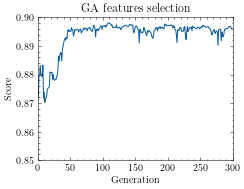

In [6]:
pparam = dict(xlabel='Generation', ylabel='Score')
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax.plot(score)
    ax.set_title("GA features selection")
    ax.autoscale(tight=True)
    ax.set(**pparam)
    ax.set_xlim([0, 300])
    ax.set_ylim([0.85, 0.9])
    fig.savefig('./GA.png', dpi=300)

In [7]:
model = LinearRegression(normalize=True)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.3, random_state=42)
chromo_df1,score1=generations2(population_nextgen,data,label,size,n_feat=data.shape[1],n_parents=30,mutation_rate=0.02,cross_rate=0.7,n_gen=500,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test,tol_level = 0.000005)

In [8]:
max_data1 = max(score1)
list_bo1 = score1.index(max_data1)
list_ch1 = chromo_df1[list_bo1]
list_ch1=list(list_ch1)
list_bo1,max_data1
print('Best score: ',max_data1,' position: ',list_bo1)  #2

Best score:  0.8991988534239603  position:  163


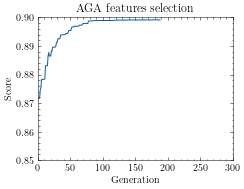

In [9]:
pparam = dict(xlabel='Generation', ylabel='Score')
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax.plot(score1)
    ax.set_title("AGA features selection")
    ax.autoscale(tight=True)
    ax.set(**pparam)
    ax.set_xlim([0, 300])
    ax.set_ylim([0.85, 0.9])
    fig.savefig('./AGA_1.png', dpi=300)

In [10]:
model = LinearRegression(normalize=True)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.3, random_state=42)
chromo_df2,score2=generations3(population_nextgen,data,label,size,n_feat=data.shape[1],n_parents=30,mutation_rate=0.02,cross_rate=0.7,n_gen=300,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test,tol_level = 0.000005)

In [11]:
max_data2 = max(score2)
list_bo2 = score2.index(max_data2)
list_ch2 = chromo_df2[list_bo2]
list_ch2=list(list_ch2)
list_bo2,max_data2
print('Best score: ',max_data2,' position: ',list_bo2)  #2

Best score:  0.8992881149749476  position:  172


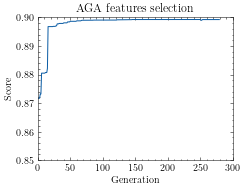

In [12]:
pparam = dict(xlabel='Generation', ylabel='Score')
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax.plot(score2)
    ax.set_title("AGA features selection")
    ax.autoscale(tight=True)
    ax.set(**pparam)
    ax.set_xlim([0, 300])
    ax.set_ylim([0.85, 0.9])
    fig.savefig('./AGA_2.png', dpi=300)

In [13]:
model = LinearRegression(normalize=True)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.3, random_state=42)
chromo_df3,score3=generations4(population_nextgen,data,label,size,n_feat=data.shape[1],n_parents=30,mutation_rate=0.02,cross_rate=0.7,n_gen=300,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test,tol_level = 0.000005)

In [14]:
max_data3 = max(score3)
list_bo3 = score3.index(max_data3)
list_ch3 = chromo_df3[list_bo3]
list_ch3=list(list_ch3)
list_bo3,max_data3
print('Best score: ',max_data3,' position: ',list_bo3)  #2

Best score:  0.8992611892932021  position:  149


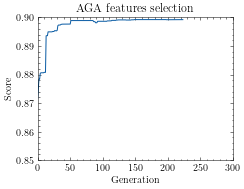

In [15]:
pparam = dict(xlabel='Generation', ylabel='Score')
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax.plot(score3)
    ax.set_title("AGA features selection")
    ax.autoscale(tight=True)
    ax.set(**pparam)
    ax.set_xlim([0, 300])
    ax.set_ylim([0.85, 0.9])
    fig.savefig('./AGA_3.png', dpi=300)

In [17]:
model = LinearRegression(normalize=True)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.3, random_state=42)
chromo_df4,score4=generations5(population_nextgen,data,label,size,n_feat=data.shape[1],n_parents=30,mutation_rate=0.02,cross_rate=0.7,n_gen=300,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test,tol_level =0.000005)

In [18]:
max_data4 = max(score4)
list_bo4 = score4.index(max_data4)
list_ch4 = chromo_df4[list_bo4]
list_ch4=list(list_ch4)
list_bo4,max_data4
print('Best score: ',max_data4,' position: ',list_bo4)  #2

Best score:  0.8992881149749476  position:  240


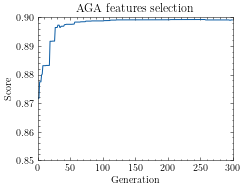

In [19]:
pparam = dict(xlabel='Generation', ylabel='Score')
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax.plot(score4)
    ax.set_title("AGA features selection")
    ax.autoscale(tight=True)
    ax.set(**pparam)
    ax.set_xlim([0, 300])
    ax.set_ylim([0.85, 0.9])
    fig.savefig('./AGA_4.png', dpi=300)

$k_1$=0.5 $k_2$=0.5 $k_3$=1 $k_4$=1
$k_1$=0.5 $k_2$=0.5 $k_3$=1 $k_4$=0.9
$k_1$=0.5 $k_2$=0.5 $k_3$=0.9 $k_4$=1
$k_1$=0.5 $k_2$=0.5 $k_3$=0.9 $k_4$=0.9


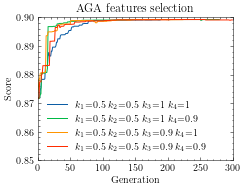

In [20]:
pparam = dict(xlabel='Generation', ylabel='Score')
labels = [r'$k_1$=0.5 $k_2$=0.5 $k_3$=1 $k_4$=1',
         r'$k_1$=0.5 $k_2$=0.5 $k_3$=1 $k_4$=0.9',
         r'$k_1$=0.5 $k_2$=0.5 $k_3$=0.9 $k_4$=1',
         r'$k_1$=0.5 $k_2$=0.5 $k_3$=0.9 $k_4$=0.9']
# labels = [1,2,3,4]
with plt.style.context(['science']):
    fig, axes = plt.subplots(2,2)
    for p,l in zip([score1, score2, score3, score4],labels):
        ax.plot(ax=axes[1,1],p, label=l)
    ax.set_title("AGA features selection")
    ax.legend()
    ax.autoscale(tight=True)
    ax.set(**pparam)
    ax.set_xlim([0, 300])
    ax.set_ylim([0.85, 0.9])
    fig.savefig('./AGA_compare.png', dpi=300)

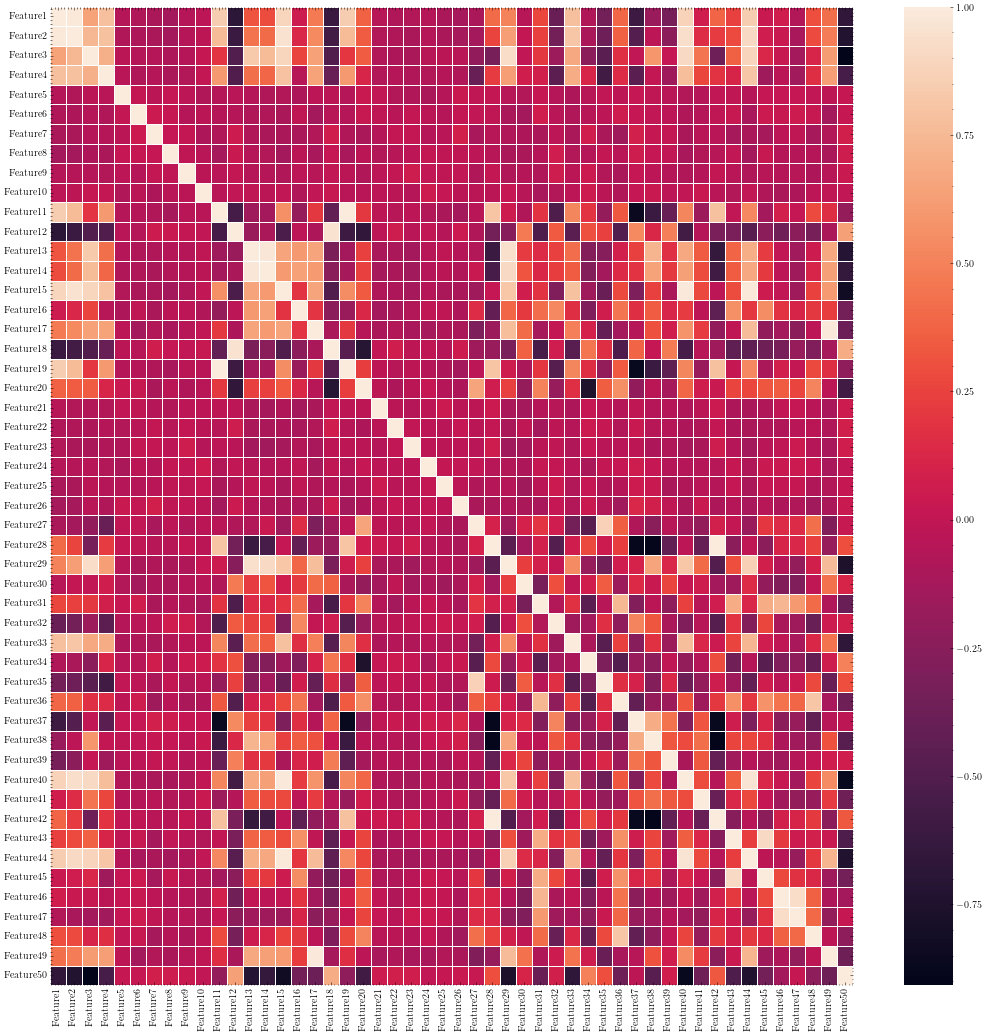

In [22]:
#correlation matrix
corrmat = data.corr()
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(corrmat.corr(), annot=False, linewidths=.5, fmt= '.1f',ax=ax)
plt.savefig("./corr_orig.png")

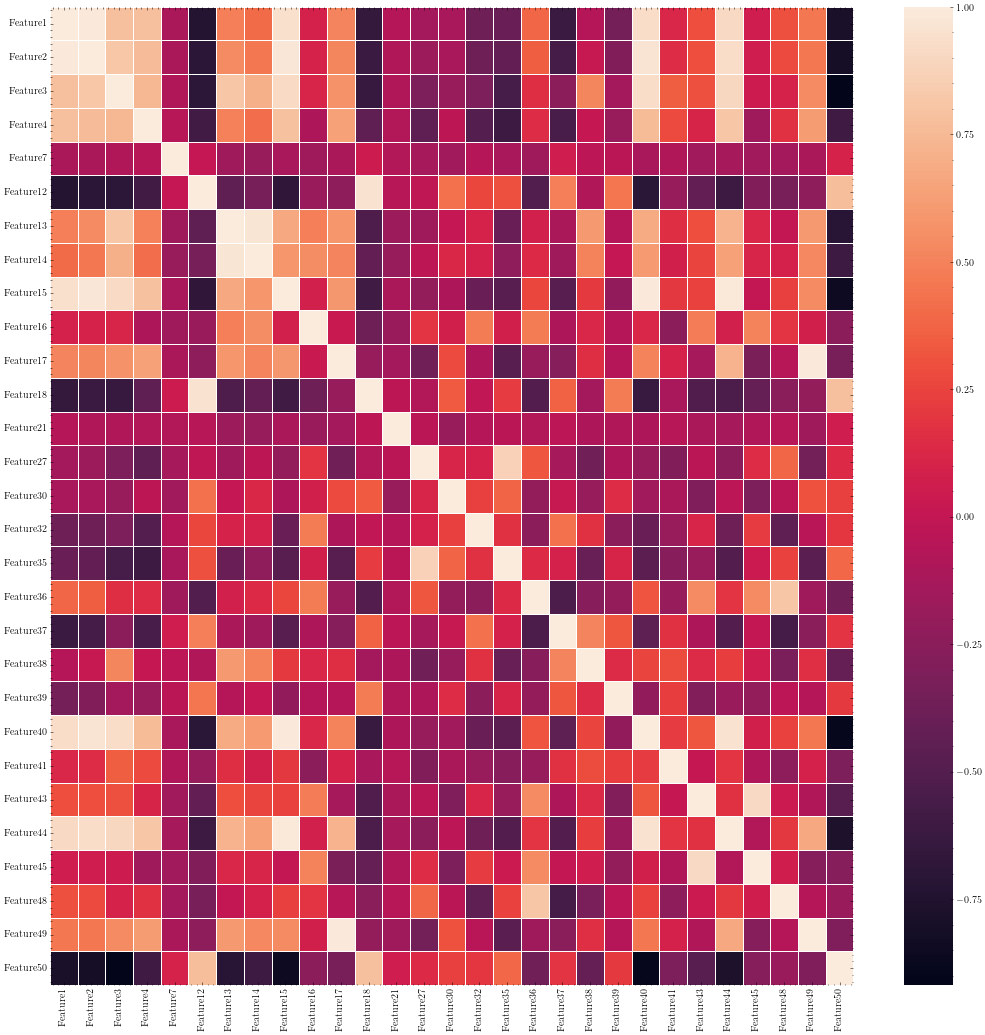

In [27]:
data_ch4 = data.iloc[:,list_ch4]
corrmat = data_ch4.corr()
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(corrmat.corr(), annot=False, linewidths=.5, fmt= '.1f',ax=ax)
plt.savefig("./corr_after.png")